# Running RAVEN on a multi-basin NetCDF file in parallel

Here we use birdy's WPS client to launch the GR4JCN hydrological model on the server for 2 basins in parallel. The NetCDF is thus a 2d file. We then analyze the outputs.

Note that we are cheating in this notebook. The input file only has one watershed, and we run the same watershed for two sets of model parameters. 

In [1]:
#Import necessary packages and start the service 
from birdy import WPSClient

from ravenpy.utilities.testdata import get_file
import datetime as dt
from urllib.request import urlretrieve
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import os

# Set environment variable WPS_URL to "http://localhost:9099" to run on the default local server
url = os.environ.get("WPS_URL", "https://pavics.ouranos.ca/twitcher/ows/proxy/raven/wps")
wps = WPSClient(url)

In [2]:
# The model parameters for gr4jcn for both catchments. Can either be a string of comma separated values, a list, an array or a named tuple. 
gr4jcn1 ='0.529, -3.396, 407.29, 1.072, 16.9, 0.947'
gr4jcn2 ='0.28, -3.6, 380.9, 1.092, 14.6, 0.831'

params=[gr4jcn1, gr4jcn2]

# Forcing files. Raven uses the same forcing files for all and extracts the information it requires for each model.
ts = get_file("input2d/input2d.nc")

# Model configuration parameters. In a real case, we'd set nc_index to two different values for two different watersheds. 
config = dict(
    start_date=[dt.datetime(2000, 1, 1),dt.datetime(2000, 1, 1)],
    end_date=[dt.datetime(2002, 1, 1),dt.datetime(2002, 1, 1)],
    area=[4250.6,5000],
    elevation=[843.0,780],
    latitude=[54.4848,48.0],
    longitude=[-123.3659,-122.99],
    nc_index=[0,0],
    )

# Launch the WPS to get the multi-model results.  Note the "gr4jcn" and "hmets" keys.
resp=wps.raven_gr4j_cemaneige(ts=str(ts),params=params, **config) 

# And get the response
# With `asobj` set to False, only the reference to the output is returned in the response. 
# Setting `asobj` to True will retrieve the actual files and copy the locally.
[hydrograph, storage, solution, diagnostics, rv] = resp.get(asobj=True)

In [3]:
ds =xr.open_dataset(ts)
ds

<xarray.Dataset>
Dimensions:       (region: 1, time: 20819)
Coordinates:
    station_name  (region) object ...
  * time          (time) datetime64[ns] 1954-01-01 1954-01-02 ... 2010-12-31
Dimensions without coordinates: region
Data variables: (12/13)
    lon           (region) float64 ...
    lat           (region) float64 ...
    rain          (time, region) float64 ...
    snow          (time, region) float64 ...
    tmin          (time, region) float64 ...
    tmax          (time, region) float64 ...
    ...            ...
    qobs          (time, region) float64 ...
    name          (region) object ...
    area          (region) float64 ...
    elevation     (region) float64 ...
    latitude      (region) float64 ...
    longitude     (region) float64 ...
Attributes:
    description:  Merge Raven ASCII-formatted timeseries used in GR4J+CEMANEI...
    history:      Created by Juliane Mai 
    Conventions:  CF-1.6
    featureType:  timeSeries

In [4]:
# Print the diagnostics for both catchments
print(diagnostics)

['observed data series,filename,DIAG_NASH_SUTCLIFFE,DIAG_RMSE,\nHYDROGRAPH_ALL,/tmp/pywps_process_htmrxsz9/input2d.nc,-0.117301,37.9493,\n', 'observed data series,filename,DIAG_NASH_SUTCLIFFE,DIAG_RMSE,\nHYDROGRAPH_ALL,/tmp/pywps_process_htmrxsz9/input2d.nc,0.21155,31.879,\n']


The `hydrograph` and `storage` outputs are netCDF files storing the time series. These files are opened by default using `xarray`, which provides convenient and powerful time series analysis and plotting tools. 

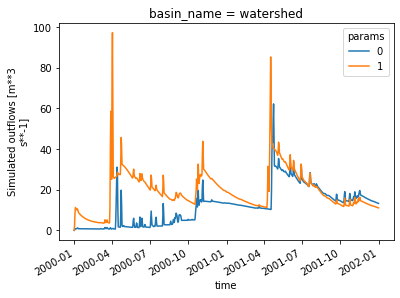

In [7]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Plot the hydrographs for both basins. In reality, hue would follow nbasins. 
hydrograph.q_sim.isel(nbasins=0).plot.line(hue='params')
plt.show()

The individual configuration files for each model run can be accessed as a Zip archive. 

In [6]:
[hydrograph_file, storage, solution, diagnostics, rv] = resp.get(asobj=False)
print ("RV configuration", rv)

RV configuration http://localhost:9099/outputs/b3ba3796-8664-11eb-afc6-28d24417f566/rv.zip
